In [1]:
%load_ext autoreload

In [29]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.fftpack import  fft, ifft, ifftshift
from scipy.signal import correlate
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import ssm
import sys

sys.path.append('/om2/user/eisenaj/code/ChaoticConsciousness')

from data_utils import *

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

# Functions

In [110]:
class VAR:
    def __init__(self, data, p=1, matrix_size=None, tau=1, dt=None, use_torch=False, device=None, dtype='torch.DoubleTensor', verbose=False):
        self.window = data.shape[-2]
        self.n = data.shape[-1]
        
        if p is not None and matrix_size is not None:
            raise ValueError("Cannot provide both p and matrix_size!!")
        elif p is None:
            self.matrix_size = matrix_size
            self.p = int(np.ceil(matrix_size/self.n))
        else: # matrix_size is None
            self.p = p
            self.matrix_size = self.n*self.p
            
        self.tau = tau
        self.dt = dt
        self.use_torch = use_torch
        
        data = numpy_torch_conversion(data, use_torch, device, dtype)
        self.data = data
        if len(data.shape) == 3:
            self.trials = True
        else:
            self.trials = False
        if use_torch:
            self.device = data.device
            self.dtype = data.type()
        else:
            self.device = None
            self.dtype = None
            
        if self.p is not None:
            self.compute_hankel(verbose=verbose)
            
        self.use_bias = None
        self.A = None
        self.B = None
        
    def compute_hankel(self, p=None, tau=None, verbose=False):
        if verbose:
            print("Computing Hankel matrix ...")
        if p is None and self.p is None:
            raise ValueError("Embedding dim p has not been provided.")
        elif p is not None:
            self.p = p
        else: # p is None and self.p is not None
            p = self.p
        
        if tau is None and self.tau is None:
            raise ValueError("Embedding dim p has not been provided.")
        elif tau is not None:
            self.tau = tau
        else: # p is None and self.p is not None
            tau = self.tau

        if self.trials:
            if self.use_torch:
                H = torch.zeros(self.data.shape[0], self.data.shape[1] - p + 1, self.data.shape[2]*p).type(self.dtype).to(self.device)
            else:
                H = np.zeros(self.data.shape[0], self.data.shape[1] - p + 1, self.data.shape[2]*p)
            for i in range(self.data.shape[0]): 
                H[i] = embed_signal(self.data[i], p, use_torch=self.use_torch, device=self.device, dtype=self.dtype)
            self.H = H
        else:
            self.H = embed_signal(self.data, p, tau, use_torch=self.use_torch, device=self.device, dtype=self.dtype)
        
        if verbose:
            print("Hankel matrix computed!")
            
    def compute_VAR_p(self, lamb=0, use_bias=False, verbose=False):
        if verbose:
            print("Computing least squares fit for VAR ...")
        
        self.use_bias = use_bias
        if use_bias:
            pass
        
        if self.trials:
            pass
        else:
            V_minus = self.H[:-1]
            V_plus = self.H[1:, :self.n]
            
        if self.use_torch:
            A = (torch.linalg.inv(V_minus.T @ V_minus  + lamb*torch.eye(V_minus.shape[1]).type(self.dtype).to(self.device)) @ V_minus.T @ V_plus).T
        else:
            A = (np.linalg.inv(V_minus.T @ V_minus + lamb*np.eye(V_minus.shape[1])) @ V_minus.T @ V_plus).T
        
        if use_bias:
            self.A = A[:, :-1]
            self.B = A[:, -1]
        else:
            self.A = A
            
        if verbose:
            print("Least squares complete!")
    
    def predict_VAR_p(self, test_data, tail_bite=False, reseed=None, full_return=False, verbose=False):
        test_data = numpy_torch_conversion(test_data, self.use_torch, self.device, self.dtype)
        H_test = embed_signal(test_data, self.p, self.tau, use_torch=self.use_torch, device=self.device, dtype=self.dtype)
        
        if tail_bite:
            if reseed is None:
                reseed = H_test.shape[0] + 1

            if self.use_torch:
                H_test_VAR = torch.zeros(H_test.shape).type(self.dtype).to(self.device)
            else:
                H_test_VAR = np.zeros(H_test.shape)
            H_test_VAR[0] = H_test[0]

            for t in range(1, H_test.shape[0]):
                if t % reseed == 0:
                    H_test_VAR[t] = self.A @ H_test[t - 1]
                else:
                    H_test_VAR[t, :self.n] = self.A @ H_test_VAR[t - 1]
                    H_test_VAR[t, self.n:]
                if self.use_bias:
                    H_test_VAR[t, :self.n] += self.B

        else:
            H_test_VAR_ = (self.A @ H_test[:-1].T).T
            if self.use_bias:
                H_test_VAR_ += self.B
            if self.use_torch:
                H_test_VAR = torch.vstack([H_test[[0], :self.n], H_test_VAR_])
            else:
                H_test_VAR = np.vstack([H_test[[0], :self.n], H_test_VAR_])

        if self.use_torch:
            pred_data = torch.vstack([test_data[:self.p], H_test_VAR[1:, :self.n]])
        else:
            pred_data = np.vstack([test_data[:self.p], H_test_VAR[1:, :self.n]])

        if full_return:
            return pred_data, H_test_VAR, H_test
        else:
            return pred_data
        
def autocorrelation(x):
    ac = np.zeros((x.shape[1], int(x.shape[0]/2)))
    for i in range(ac.shape[0]):
        stdev = np.std(x[:,i])
        if stdev == 0:
            inp = x[:, i]
        else:
            inp = (x[:,i] - np.average(x[:,i]))/stdev
        xp = ifftshift(inp)
        n, = xp.shape
        xp = np.r_[xp[:n//2], np.zeros_like(xp), xp[n//2:]]
        f = fft(xp)
        p = np.absolute(f)**2
        pi = ifft(p)
        ac[i] = np.real(pi)[:n//2]/(np.arange(n//2)[::-1]+n//2)
    return ac

def get_fft(x, dt=1, min_freq=0, max_freq=500, spectrum_smoothing_width=0, log=False, standardize=False):
    fft = np.zeros((x.shape[1], int(x.shape[0]/2) + 1))
    for i in range(x.shape[1]):
        stdev = x[:, i].std()
        if standardize and stdev != 0:
            inp = (x[:, i] - x[:,i].mean())/stdev
        else:
            inp = x[:, i]
        fft[i] = np.abs(np.fft.rfft(inp))
    freqs = np.fft.rfftfreq(x.shape[0], d=dt)
    
    freq_inds = np.logical_and(freqs >= min_freq, freqs <= max_freq)
    fft = fft[:, freq_inds]
    freqs = freqs[freq_inds]
    
    df = freqs[0]
    if spectrum_smoothing_width > 0:
        for i in range(fft.shape[0]):
            fft[i] = scipy.ndimage.gaussian_filter1d(fft[i], spectrum_smoothing_width/df)
    
    if log:
        fft = 10*np.log10(fft)
    
    if standardize:
        for i in range(fft.shape[0]):
            fft[i] = (fft[i] - fft[i].mean())/fft.std()
    
    return fft

def testing_suite(pred, true, p=1, reseed=1, num_lags=None, dt=1):
    pred_inds = np.arange(p + reseed - 2, true.shape[0], reseed)
    mse_indexed = ((pred[pred_inds] - true[pred_inds])**2).mean()
    r2_indexed = r2_score(true[pred_inds], pred[pred_inds])
    correl_indexed = np.zeros(pred.shape[1])
    for i in range(pred.shape[1]):
        correl_indexed[i] = scipy.stats.pearsonr(pred[pred_inds, i], true[pred_inds, i])[0]
    autocorrelation(pred)

    mse_full = ((pred[p:] - true[p:])**2).mean()
    r2_full = r2_score(true[p:], pred[p:])
    correl_full = np.zeros(pred.shape[1])
    for i in range(pred.shape[1]):
        correl_full[i] = scipy.stats.pearsonr(pred[p:, i], true[p:, i])[0]
    
    # AUTOCORRELATIONS
    
    autocorrel_correl = np.zeros(pred.shape[1])
    autocorrel_r2 = np.zeros(pred.shape[1])
    
    autocorrel_pred = autocorrelation(pred)
    autocorrel_true = autocorrelation(true)
    if num_lags is None:
        num_lags = autocorrel_pred.shape[1]
    for i in range(pred.shape[1]):
        autocorrel_correl[i] = scipy.stats.pearsonr(autocorrel_pred[i][:num_lags], autocorrel_true[i][:num_lags])[0]
        autocorrel_r2[i] = r2_score(autocorrel_true[i][:num_lags], autocorrel_pred[i][:num_lags])
    
    # PREDICTIONS
    
    fft_correl = np.zeros(pred.shape[1])
    fft_r2 = np.zeros(pred.shape[1])
    
    fft_pred = get_fft(pred, dt=dt, min_freq=0, max_freq=500, spectrum_smoothing_width=0, log=False, standardize=False)
    fft_true = get_fft(true, dt=dt, min_freq=0, max_freq=500, spectrum_smoothing_width=0, log=False, standardize=False)
    
    for i in range(pred.shape[1]):
        fft_correl[i] = scipy.stats.pearsonr(fft_pred[i], fft_true[i])[0]
        fft_r2[i] = r2_score(fft_true[i], fft_pred[i])
        
        
    return dict(
        mse_indexed=mse_indexed,
        r2_indexed=r2_indexed,
        correl_indexed=correl_indexed,
        mse_full=mse_full,
        r2_full=r2_full,
        correl_full=correl_full,
        autocorrel_correl=autocorrel_correl,
        autocorrel_r2=autocorrel_r2,
        fft_correl=fft_correl,
        fft_r2=fft_r2,
    )

# Load Data

## Background

In [3]:
# session_list = os.listdir("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results")
# session_list = session_list[:2]
# # session_list = session_list[4:]

In [4]:
session = 'MrJones-Anesthesia-20160301-01'

# -----------------------------------------
# LOAD DATA AND DIRECTORY
# -----------------------------------------
print("loading data...")
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
#     areas = np.unique(electrode_info['area'])
# areas = np.hstack([areas, 'all'])
areas = ['all']

print("data loaded!")
print("loading directory")

chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

print("directory loaded!")


area = 'all'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

norm_folder = "NOT_NORMED"

# -----------------------------------------
# LOAD GRID SEARCH RESULTS
# -----------------------------------------

session_results = {}
session_results[session] = {}
# data_processing_df_grid = deepcopy(mp_args.data_processing_df)

grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
areas = os.listdir(os.path.join(grid_results_dir, session, norm_folder))

for area in areas:
    df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
    for f in os.listdir(os.path.join(grid_results_dir, session, norm_folder, area)):
        t = float(f.split('_')[0])
        file_path = os.path.join(grid_results_dir, session, norm_folder, area, f)
        df_new = pd.DataFrame(pd.read_pickle(file_path))
        if np.isnan(df_new.AIC).sum() > 0:
            print(file_path)
        df_new = df_new.set_index(['window', 'matrix_size', 'r'])
        for i, row in df_new.iterrows():
            if i in df.index:
                df.loc[i, 'AICs'].append(row.AIC)
                df.loc[i, 'time_vals'].append(t)
                df.loc[i, 'file_paths'].append(file_path)
            else:
                df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}

    df = df.loc[df.index.sortlevel()[0]]
    session_results[session][area] = df

print("Grid search results loaded!")

# ================
# INDIVIDUAL AREAS
# ================ 
window_ind, matrix_size_ind, r_ind, all_results_ind = combine_grid_results({key: result for key, result in session_results[session].items() if key !='all'})

# ================
# ALL AREAS
# ================ 
if 'all' in session_results[session].keys():
    window_all, matrix_size_all, r_all, all_results_all = combine_grid_results({key: result for key, result in session_results[session].items() if key =='all'})

if area == 'all':
    window, matrix_size, r = window_all, matrix_size_all, r_all
else:
    window, matrix_size, r = window_ind, matrix_size_ind, r_ind

loading data...
data loaded!
loading directory
directory loaded!
Grid search results loaded!


## Load Signals

In [5]:
session_info['drugStart']

array([2589.5427, 4389.5427])

In [8]:
subsample = 1

window = 15*subsample # s
T_pred = 4*subsample # s

# start_times = [500] # s
start_times = [4000] # s

In [9]:
signals = []
for t in tqdm(start_times):   
    signal_train = load_window_from_chunks(t, t + window, directory)
    signal_test = load_window_from_chunks(t + window, t + window + T_pred, directory)
    signals.append((signal_train, signal_test))

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
signal_train = signal_train[np.arange(0, signal_train.shape[0], subsample)]
signal_test = signal_test[np.arange(0, signal_test.shape[0], subsample)]

# Analyze

In [125]:
thresh = 0.99
pca = PCA(n_components=signal_train.shape[1]).fit(signal_train)
ind = np.argmax(np.cumsum(pca.explained_variance_ratio_) > thresh)

In [47]:
signal_train_pca = pca.transform(signal_train)[:, :ind]

In [127]:
# stpca_inv = np.hstack([signal_train_pca, np.zeros((signal_train_pca.shape[0], signal_train.shape[1] - signal_train_pca.shape[1]))])
# signal_train_pca_inv = pca.inverse_transform(stpca_inv)

In [128]:
signal_train_pca.shape

(15000, 34)

In [129]:

# var = VAR(signal_train)
# var.compute_VAR_p()


delase = DeLASE(signal_train, matrix_size=matrix_size, dt=dt, device='cuda')
delase.fit(max_freq=500, max_unstable_freq=125, rank_thresh=0.075)

delase_big = DeLASE(signal_train, n_delays=28, dt=dt, device='cuda')
delase_big.fit(max_freq=500, max_unstable_freq=125, rank_thresh=0.075)

delase_pca = DeLASE(signal_train_pca, n_delays=28, dt=dt, device='cuda')
delase_pca.fit(max_freq=500, max_unstable_freq=125, rank_thresh=0.075)

delase_pca2 = DeLASE(signal_train_pca, matrix_size=6400, dt=dt, device='cuda')
delase_pca2.fit(max_freq=500, max_unstable_freq=125, rank_thresh=0.075)


# delase_big = DeLASE(signal_train, p=3, tau=20, use_torch=True, device='cuda')
# delase_big.compute_havok_dmd(r_thresh=0.1)

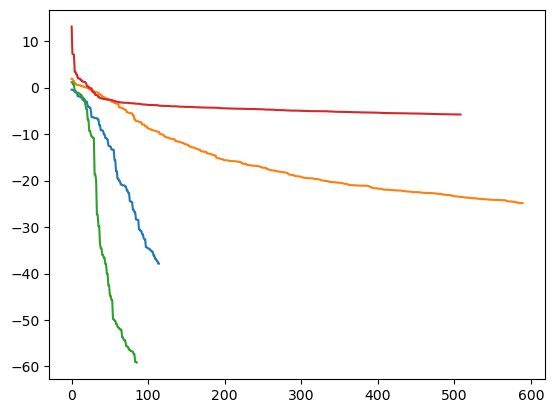

In [130]:
top_percent = 0.1
plt.plot(delase.stability_params[:int(top_percent*len(delase.stability_params))].cpu())
plt.plot(delase_big.stability_params[:int(top_percent*len(delase_big.stability_params))].cpu())
plt.plot(delase_pca.stability_params[:int(top_percent*len(delase_pca.stability_params))].cpu())
plt.plot(delase_pca2.stability_params[:int(top_percent*len(delase_pca2.stability_params))].cpu())
plt.show()

In [131]:
pred_delase = delase.DMD.predict(signal_test).cpu().numpy()
pred_delase_big = delase_big.DMD.predict(signal_test).cpu().numpy()

signal_test_pca = pca.transform(signal_test)[:, :ind]
pred_delase_pca = delase_pca.DMD.predict(signal_test_pca).cpu().numpy()
stack = np.hstack([signal_test_pca, np.zeros((signal_test_pca.shape[0], signal_test.shape[1] - signal_test_pca.shape[1]))])
signal_test_pca_inv = pca.inverse_transform(stack)

stack = np.hstack([pred_delase_pca, np.zeros((pred_delase_pca.shape[0], signal_test.shape[1] - pred_delase_pca.shape[1]))])
pred_delase_pca_inv = pca.inverse_transform(stack)

pred_delase_pca2 = delase_pca2.DMD.predict(signal_test_pca).cpu().numpy()

stack = np.hstack([pred_delase_pca2, np.zeros((pred_delase_pca2.shape[0], signal_test.shape[1] - pred_delase_pca2.shape[1]))])
pred_delase_pca2_inv = pca.inverse_transform(stack)

In [132]:
print(f"DeLASE: {((signal_test - pred_delase)**2).mean()}")
print(f"DeLASE Big: {((signal_test - pred_delase_big)**2).mean()}")
print(f"DeLASE PCA in PCA Space: {((signal_test_pca - pred_delase_pca)**2).mean()}")
print(f"DeLASE PCA in Neural Space (compred to inverted): {((signal_test_pca_inv - pred_delase_pca_inv)**2).mean()}")
print(f"DeLASE PCA in Neural Space (compared to original): {((signal_test - pred_delase_pca_inv)**2).mean()}")

print(f"DeLASE PCA2 in PCA Space: {((signal_test_pca - pred_delase_pca2)**2).mean()}")
print(f"DeLASE PCA2 in Neural Space (compred to inverted): {((signal_test_pca_inv - pred_delase_pca2_inv)**2).mean()}")
print(f"DeLASE PCA2 in Neural Space (compared to original): {((signal_test - pred_delase_pca2_inv)**2).mean()}")

DeLASE: 4.621082181016547e-06
DeLASE Big: 9.645180891732171e-06
DeLASE PCA in PCA Space: 7.690344366006731e-06
DeLASE PCA in Neural Space (compred to inverted): 1.1368335149749088e-06
DeLASE PCA in Neural Space (compared to original): 0.00025917151196543846
DeLASE PCA2 in PCA Space: 1.4920668261796225e-05
DeLASE PCA2 in Neural Space (compred to inverted): 2.205664003917704e-06
DeLASE PCA2 in Neural Space (compared to original): 0.0002602403424543811


In [137]:
print(f"DeLASE: {r2_score(signal_test, pred_delase)}")
print(f"DeLASE Big: {r2_score(signal_test, pred_delase_big)}")
print(f"DeLASE PCA in PCA Space: {r2_score(signal_test_pca, pred_delase_pca)}")
print(f"DeLASE PCA in Neural Space (compred to inverted): {r2_score(signal_test_pca_inv, pred_delase_pca_inv)}")
print(f"DeLASE PCA in Neural Space (compared to original): {r2_score(signal_test, pred_delase_pca_inv)}")

print(f"DeLASE PCA2 in PCA Space: {r2_score(signal_test_pca, pred_delase_pca2)}")
print(f"DeLASE PCA2 in Neural Space (compred to inverted): {r2_score(signal_test_pca_inv, pred_delase_pca2_inv)}")
print(f"DeLASE PCA2 in Neural Space (compared to original): {r2_score(signal_test, pred_delase_pca2_inv)}")

DeLASE: 0.9993245319894727
DeLASE Big: 0.998597761089841
DeLASE PCA in PCA Space: 0.9981787119255692
DeLASE PCA in Neural Space (compred to inverted): 0.9998352330967635
DeLASE PCA in Neural Space (compared to original): 0.9615933794631056
DeLASE PCA2 in PCA Space: 0.9964400192105276
DeLASE PCA2 in Neural Space (compred to inverted): 0.9996893784274046
DeLASE PCA2 in Neural Space (compared to original): 0.9614578217087499


In [172]:
rslds = ssm.SLDS(signal_train.shape[1], 4, 10, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(signal_train)

In [174]:
q_elbos_bbvi, q_bbvi = rslds.fit(signal_train, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

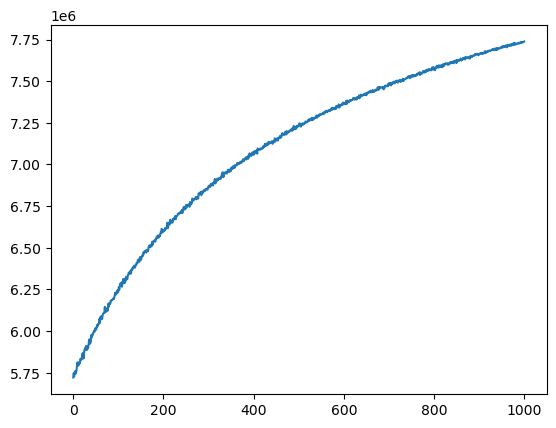

In [175]:
plt.plot(q_elbos_bbvi)

In [184]:
, signa

<bound method ensure_slds_args_not_none.<locals>.wrapper of <ssm.lds.SLDS object at 0x2b4e175cd460>>

In [189]:
q_bbvi

In [236]:
def predict(data, rslds):
    C = np.mean(rslds.emissions.Cs, axis=0)
    d = np.mean(rslds.emissions.ds, axis=0)
    C_pseudoinv = np.linalg.solve(C.T.dot(C), C.T).T
    x = (data - d).dot(C_pseudoinv)
    z = rslds.most_likely_states(x, data)
    z_pred, x_pred, y_pred = rslds.sample(T = 10, prefix = (z, x, data))
    return z_pred, x_pred, y_pred

In [238]:
z_pred, x_pred, y_pred = predict(signal_train[:1], rslds)

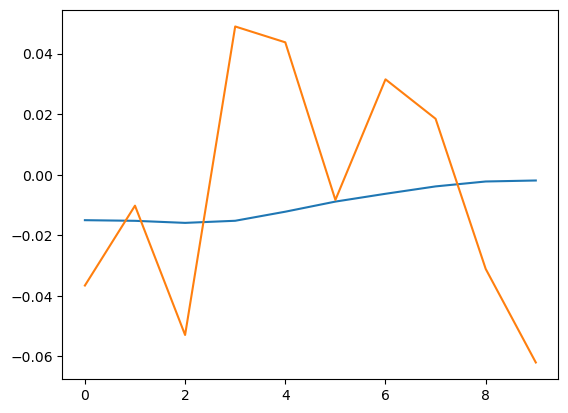

In [245]:
plt.plot(signal_train[1:11, 0])
plt.plot(y_pred[:, 0])